In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [2]:
twitter_file = "data/Tweets.csv"
df = pd.read_csv(twitter_file).dropna()
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [3]:
# get class values based on categories
cat_id = {"neutral": 1, "negative": 0, "positive": 2}

df["class"] = df["sentiment"].map(cat_id)

In [4]:
# Hyperparameters
BATCH_SIZE = 512
NUM_EPOCHS = 80

In [5]:
# separate independent and dependent features
X = df["text"].values
y = df["class"].values

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=123
)
print(
    f"X train: {X_train.shape}, y train: {y_train.shape}\nX test: {X_test.shape}, y test: {y_test.shape}"
)

one_hot = CountVectorizer()
X_train_onehot = one_hot.fit_transform(X_train)
X_test_onehot = one_hot.transform(X_test)

X train: (13740,), y train: (13740,)
X test: (13740,), y test: (13740,)


In [6]:
# Dataset Class
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


train_ds = SentimentData(X=X_train_onehot, y=y_train)
test_ds = SentimentData(X_test_onehot, y_test)

In [7]:
# Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

In [8]:
# Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [9]:
# Model, Loss and Optimizer
model = SentimentModel(NUM_FEATURES=X_train_onehot.shape[1], NUM_CLASSES=3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

/home/prajwal/NLP and GenAI/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prajwal/NLP and GenAI/env/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [10]:
# Model Training
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

Epoch 0, Loss: 29.762775182724
Epoch 1, Loss: 28.529885172843933
Epoch 2, Loss: 26.84921622276306
Epoch 3, Loss: 24.93662041425705
Epoch 4, Loss: 23.010600805282593
Epoch 5, Loss: 21.179175794124603
Epoch 6, Loss: 19.50905692577362
Epoch 7, Loss: 17.981294572353363
Epoch 8, Loss: 16.619835436344147
Epoch 9, Loss: 15.398369491100311
Epoch 10, Loss: 14.30932030081749
Epoch 11, Loss: 13.34882253408432
Epoch 12, Loss: 12.473806411027908
Epoch 13, Loss: 11.696585565805435
Epoch 14, Loss: 11.008902132511139
Epoch 15, Loss: 10.381650030612946
Epoch 16, Loss: 9.80532130599022
Epoch 17, Loss: 9.288521438837051
Epoch 18, Loss: 8.821797996759415
Epoch 19, Loss: 8.387735366821289
Epoch 20, Loss: 7.991757422685623
Epoch 21, Loss: 7.628403469920158
Epoch 22, Loss: 7.286630809307098
Epoch 23, Loss: 6.986356899142265
Epoch 24, Loss: 6.6855582892894745
Epoch 25, Loss: 6.420519158244133
Epoch 26, Loss: 6.160072639584541
Epoch 27, Loss: 5.928837448358536
Epoch 28, Loss: 5.705528080463409
Epoch 29, Loss: 

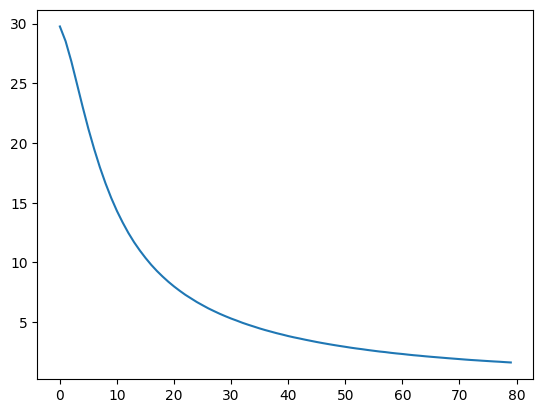

In [11]:
sns.lineplot(x=list(range(len(train_losses))), y=train_losses)
plt.show()

In [13]:
# Model Evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim=1)


y_test_pred_np = y_test_pred.squeeze().cpu().numpy()


acc = accuracy_score(y_pred=y_test_pred_np, y_true=y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."

'The accuracy of the model is 63.3%.'

In [14]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")

Naive Classifier: 41.0 %


<Axes: >

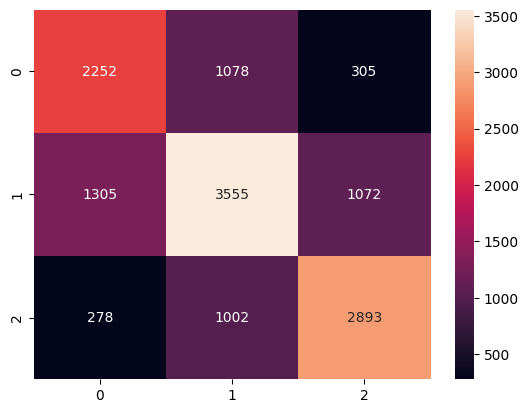

In [15]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")